In [1]:
import PreProcessMetadata
import PreProcess_NLP
import math
import pandas as pd
import networkx as nx
from matplotlib import cm
import pathlib
import matplotlib.pyplot as plt
import matplotlib.colors as pltcol
pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [524]:
#Erzeuge Knoten, Kanten aus Datei mit Metadaten
def get_entity_rel(meta, KG_entities, keyword_list_paper, keyword_list_con):
    
    for i in range(len(meta)):
        meta['Titles'][i] = meta['Titles'][i].strip()
        meta['Conference'][i] = meta['Conference'][i].strip()
        meta['Date'][i] = meta['Date'][i].strip()
        
        cur_authors =  meta['Authors'][i].split(',')
        #Kantenerstellung zwischen allen Titeln und Erstellungsdatum als Attribut
        KG_entities.add_node(meta['Titles'][i], date=meta['Date'][i], color=0.8, typ='Titel')
        KG_entities.add_node(meta['Conference'][i], color=3.2, typ='Konferenz')
        #Kantenerstellung zwischen Überklasse paper und allen Titeln 
        KG_entities.add_edge(meta['Titles'][i], 'Paper', label='ist')
        #Beziehung zwischen Überklasse Konferenz und allen Konferenztiteln
        KG_entities.add_edge(meta['Conference'][i], 'Konferenz', label='ist')
        #Beziehung zwischen Titel und Konferenz
        KG_entities.add_edge(meta['Titles'][i], meta['Conference'][i], label='ist Teil von')
        #Erstellung Knoten für Autoren und deren Verbindungen
        for author in cur_authors:
            author = author.strip()
            KG_entities.add_node(author, color=2, typ='Autor')
            KG_entities.add_edge(author, meta['Titles'][i], label='hat verfasst')
            KG_entities.add_edge(author, 'Autor', label='ist')
        #Themen paper
        for j in range(len(keyword_list_paper['keywords'])):
            if keyword_list_paper['relevance'][j] > 0.48:
                if not keyword_list_paper['keywords'][j] in KG_entities.nodes:
                    KG_entities.add_node(keyword_list_paper['keywords'][j], color=10.5, typ='Thema paper')
                    KG_entities.add_edge(keyword_list_paper['keywords'][j], 'Themengebiet', label='ist')
                    if meta['Titles'][i] == keyword_list_paper['paper'][j]:
                        KG_entities.add_edge(meta['Titles'][i], keyword_list_paper['keywords'][j], label='thematisiert')
        #Themen Konferenzen     
        for j in range(len(keyword_list_con['keywords'])):
            if keyword_list_con['relevance'][j] > 0.43:
                if not keyword_list_con['keywords'][j] in KG_entities.nodes:
                    KG_entities.add_node(keyword_list_con['keywords'][j], color=10.2, typ='Thema Konferenz')
                    KG_entities.add_edge(keyword_list_con['keywords'][j], 'Themengebiet', label='ist')
                    if meta['Conference'][i] == keyword_list_con['conference'][j]:
                        KG_entities.add_edge(meta['Conference'][i], keyword_list_con['keywords'][j], label="thematisiert")

    return KG_entities

In [3]:
#Farbschema des Graphen
def kg_colors(graph, vmin=0, vmax=7):
    cnorm = pltcol.Normalize(vmin=vmin, vmax=vmax)
    cpick = cm.ScalarMappable(norm=cnorm, cmap='turbo')
    cpick.set_array([])
    val_map = {}
    for k, v in nx.get_node_attributes(graph, 'color').items():
        val_map[k] = cpick.to_rgba(v)
    colors = []
    for node in graph.nodes():
        colors.append(val_map[node])
    return colors

In [4]:
pdf_path = ('C:/Users/Jana/LabCode/PDF')
p = pathlib.Path(pdf_path)
files_path = list(p.glob('*.pdf'))

pdf_path_conference = ('C:/Users/Jana/LabCode/AimsAndScope')
p_conference = pathlib.Path(pdf_path_conference)
files_path_conference = list(p_conference.glob('*.pdf'))

path = 'C:/Users/Jana/LabCode/'

In [5]:
# Einlesen der PDF's
df_pdf_meta = PreProcessMetadata.read_paper_meta(path)
PreProcessMetadata.write_paper_meta(path, df_pdf_meta)
PreProcessMetadata.write_conference_meta(path, df_pdf_meta)

In [6]:
corpus = PreProcess_NLP.build_corpus(files_path)
conference_corpus = PreProcess_NLP.build_conference(files_path_conference)

keyword_list, conference_list = PreProcess_NLP.generate_keywords(corpus, conference_corpus)

In [525]:
#Initialerstellung Graph
G_KG= nx.DiGraph()


#Erstellung initial fester Knoten
G_KG.add_node("Paper", color=0.9, typ='class')
G_KG.add_node("Autor", color=2, typ='class')
G_KG.add_node("Konferenz", color=3, typ='class')
G_KG.add_node("Themengebiet", color=10, typ='class')



G_KG = get_entity_rel(df_pdf_meta, G_KG, keyword_list, conference_list)

colors = kg_colors(G_KG)

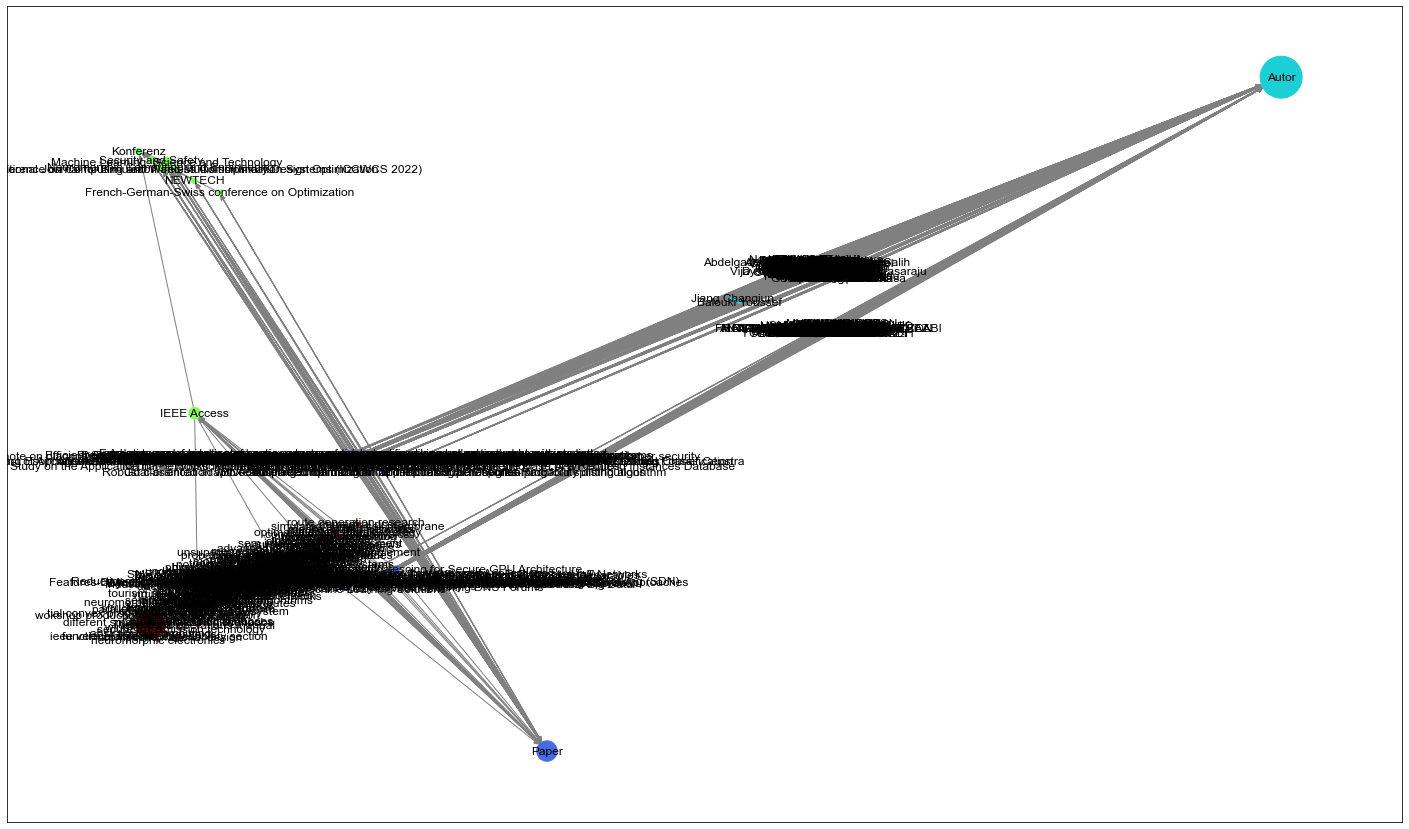

In [9]:
#Ausgabe Graph
plt.figure(figsize=(25,15))
pos = nx.spring_layout(G_KG, k=10/math.sqrt(G_KG.order())) # richtiges Layout noch finden
d = dict(G_KG.degree)


pos = nx.spring_layout(G_KG)  #setting the positions with respect to G, not k.


#print(G_Meta['Konferenz','Paper'])
nx.draw_networkx(G_KG, with_labels=True, pos=pos, node_size=[v * 5 for v in d.values()], node_color=colors, edge_color= 'grey', font_family = 'Arial')
plt.show()

In [583]:
nx.info(G_KG)

Autor


C:\Users\Jana\AppData\Local\Temp\ipykernel_17836\4188235542.py:1: DeprecationWarning: info is deprecated and will be removed in version 3.0.

  nx.info(G_KG)


In [744]:
def mergeDictionary(dict_1, dict_2):
    
    dict_3 = {**dict_1, **dict_2}

    keys_1 = list(dict_1.keys())
    keys_2 = list(dict_2.keys())

    if keys_1[0] == "Titel" and keys_2[0] == 'Titel':
        return dict_1
    if 'Konferenz' in dict_1.keys() and keys_2[0] == 'Autor' and keys_1[0] == "Titel":
        return dict_1
    if keys_1[0] == "Konferenz" and keys_2[0] == 'Thema paper':#noch ausbauen
        return dict_1
    if keys_1[0] == "Autor" and keys_2[0] == 'Thema Konferenz':#noch ausbauen
        return dict_1

    else:

        for key, value in dict_3.items():
            if key in dict_1 and key in dict_2:
                if (value not in dict_3):
                    dict_3[key] = [value , dict_1[key]]
                else:
                    if not isinstance(dict_3[key], list):
                        dict_3[key] = [dict_3[key]]
                    dict_3[key].append(value)
    
        return dict_3

In [745]:
def query_graph(n,visited,selects={},node_type=''): 
   
    selects_tmp={}
    if n not in visited:
        visited.add(n)  
        if G_KG.nodes[n]['typ'] != 'class':
            cur_node_type = G_KG.nodes[n]['typ']
            selects_tmp[cur_node_type] = n
            
            if n not in selects_tmp:
                selects_tmp[cur_node_type] = n
            else:
                if not isinstance(selects_tmp[cur_node_type], list):
                    selects_tmp[cur_node_type] = [selects_tmp[n]]
                selects_tmp[cur_node_type].append(n)
                
            if bool(selects) == True:
                selects = mergeDictionary(selects,selects_tmp)
            else:
                selects = selects_tmp
   
        for neighbour in nx.all_neighbors(G_KG, n):
            if G_KG.nodes[neighbour]['typ'] == 'class' or neighbour in visited:
         
                continue
            else:
                
                selects = query_graph(neighbour,visited,selects)
        
    return selects

In [746]:
searchy = 'A Comprehensive Study of DNS Operational Issues by Mining DNS Forums'

attr_edge = nx.get_edge_attributes(G_KG,'label')
#print(attr_edge)
typ=''
selects={}
visited = set()
if searchy in G_KG.nodes:
    for n in G_KG.nodes:
        if n.find(searchy)!= -1:
            selects=(query_graph(n,visited))
print('erg:',selects)


erg: {'Titel': 'A Comprehensive Study of DNS Operational Issues by Mining DNS Forums', 'Autor': ['ZHOU LI', ['QIFAN ZHANG', ['JIACEN XU', 'XIANRAN LIAO']]], 'Konferenz': 'IEEE Access', 'Thema Konferenz': ['ieee pspb operations manual', 'ieee access'], 'Thema paper': ['reliable dns infrastructure', 'mining dns forums']}


In [688]:

                    #if G_KG.edges[neighbour,n]['label']:
                        #cur_edge_type = G_KG.edges[neighbour,n]['label']
                    #else:
                        #G_KG.edges[n,neighbour]['label']
                    flag = False
    for k in attr_edge.keys():
        if k[1] == 'Autor' and G_KG.has_edge(n, k[0]):
            flag = True
            selects_tmp[k[1]] = k[0]
            if selects_tmp.values() not in selects_tmp_merge.values():
                if k[1] not in selects_tmp_merge:
                    selects_tmp_merge[k[1]] = k[0]
                else:
                    if not isinstance(selects_tmp_merge[k[1]], list):
                        selects_tmp_merge[k[1]] = [selects_tmp_merge[k[1]]]
                    selects_tmp_merge[k[1]].append(k[0])
        if k[1] == 'Paper' and G_KG.has_edge(n, k[0]):
            flag = True
            selects_tmp[k[1]] = k[0]
            if selects_tmp.values() not in selects_tmp_merge.values():
                if k[1] not in selects_tmp_merge:
                    selects_tmp_merge[k[1]] = k[0]
                else:
                    if not isinstance(selects_tmp_merge[k[1]], list):
                        selects_tmp_merge[k[1]] = [selects_tmp_merge[k[1]]]
                    selects_tmp_merge[k[1]].append(k[0])
        if k[1] == 'Konferenz' and G_KG.has_edge(n, k[0]):
            flag = True
            selects_tmp[k[1]] = k[0]
            
            if selects_tmp.values() not in selects_tmp_merge.values():
                if k[1] not in selects_tmp_merge:
                    selects_tmp_merge[k[1]] = k[0]
                else:
                    if not isinstance(selects_tmp_merge[k[1]], list):
                        selects_tmp_merge[k[1]] = [selects_tmp_merge[k[1]]]
                    selects_tmp_merge[k[1]].append(k[0])

        if k[1] == 'Themengebiet' and G_KG.has_edge(n, k[0]):
            flag = True
            selects_tmp[k[1]] = k[0]
            if selects_tmp.values() not in selects_tmp_merge.values():
                if k[1] not in selects_tmp_merge:
                    selects_tmp_merge[k[1]] = k[0]
                else:
                    if not isinstance(selects_tmp_merge[k[1]], list):
                        selects_tmp_merge[k[1]] = [selects_tmp_merge[k[1]]]
                    selects_tmp_merge[k[1]].append(k[0])
    
    
    if flag == True:

IndentationError: unexpected indent (3632088955.py, line 6)